In [ ]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Plots e avaliação
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import umap.umap_ as umap
import os
import math

## Rode abaixo, apenas se não tiver os datasets

In [2]:
# import kagglehub

# # Download da versão mais recente

# path = kagglehub.dataset_download("aibloy/fairface")

# print("Path to dataset files:", path)

In [3]:
CONFIG = {
    'batch_size': 128,          
    'lr': 0.0001,                
    'epochs': 10,
    'num_classes': 7,            # Ex: FairFace (White, Black, Indian, East/SE Asian, Middle East, Hispanic)
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'data_dir': 'FairFace',     
    'model_name': 'vgg16',    # Opções: 'vit_b_16', 'resnet50', 'resnet34', 'resnet101', 'efficientnet', 'vgg16'
    'use_arcface': True,         # LIGA/DESLIGA o ArcFace
    'embedding_size': 512       
}

print(f"Executando {CONFIG['model_name']} com ArcFace={CONFIG['use_arcface']} em: {CONFIG['device']}")

Executando vgg16 com ArcFace=True em: cuda


In [4]:
class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label=None):
        # 1. Normaliza features e pesos 
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        
        if label is None:
            return cosine * self.s

        # 2. Aplica a margem angular apenas na classe correta
        # cos(theta + m) = cos(theta)cos(m) - sin(theta)sin(m)
        phi = cosine - self.m # Aproximação simplificada robusta para treinamento
        
        # One-hot encoding para aplicar a margem apenas no target
        one_hot = torch.zeros(cosine.size(), device=CONFIG['device'])
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        # Logits finais: classe correta ganha penalidade, forçando aprendizado
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        return output

In [5]:
class ModelWrapper(nn.Module):
    def __init__(self, base_model, input_features, num_classes, use_arcface=False):
        super(ModelWrapper, self).__init__()
        self.features = base_model
        self.use_arcface = use_arcface
        
        # Camada de projeção para garantir tamanho fixo do embedding
        self.embedding_layer = nn.Linear(input_features, CONFIG['embedding_size'])
        self.bn = nn.BatchNorm1d(CONFIG['embedding_size']) # BN ajuda muito no ArcFace
        
        if use_arcface:
            self.classifier = ArcFaceLayer(CONFIG['embedding_size'], num_classes)
        else:
            self.classifier = nn.Linear(CONFIG['embedding_size'], num_classes)
        
    def forward(self, x, labels=None):
        # Extração de features
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        
        # Gera Embedding
        embeddings = self.embedding_layer(x)
        embeddings = self.bn(embeddings)
        
        # Classificação (ArcFace precisa dos labels no treino)
        if self.use_arcface and labels is not None:
            logits = self.classifier(embeddings, labels)
        else:
            logits = self.classifier(embeddings)
            
        return logits, embeddings

def get_model(model_name, num_classes):
    print(f"Carregando {model_name}...")
    
    if model_name == 'vit_b_16':
        # Vision Transformer SOTA
        base = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        num_ftrs = base.heads.head.in_features
        base.heads = nn.Identity() # Remove a cabeça original
        
    elif model_name == 'resnet50':
        base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = base.fc.in_features
        base.fc = nn.Identity()

    elif model_name == 'resnet34':
        base = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        num_ftrs = base.fc.in_features
        base.fc = nn.Identity()
    
    elif model_name == 'resnet101':
        base = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        num_ftrs = base.fc.in_features
        base.fc = nn.Identity()
        
    elif model_name == 'efficientnet':
        base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        num_ftrs = base.classifier[1].in_features
        base.classifier = nn.Identity()
        
    elif model_name == 'vgg16':
        base = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        num_ftrs = base.classifier[6].in_features
        base.classifier[6] = nn.Identity()
        
    else:
        raise ValueError("Modelo desconhecido")

    model = ModelWrapper(base, num_ftrs, num_classes, CONFIG['use_arcface'])
    return model.to(CONFIG['device'])

In [6]:
def train_model(model, dataloaders, criterion, optimizer):
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(CONFIG['epochs']):
        print(f'Epoch {epoch+1}/{CONFIG["epochs"]}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(CONFIG['device'])
                labels = labels.to(CONFIG['device'])

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # ArcFace precisa dos labels no forward pass durante o treino
                    if phase == 'train' and CONFIG['use_arcface']:
                        logits, _ = model(inputs, labels)
                    else:
                        logits, _ = model(inputs) # Validação ou Softmax normal
                        
                    loss = criterion(logits, labels)
                    _, preds = torch.max(logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
    return model, history

In [7]:
def plot_training_history(history):
    
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Subplot 1 - Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Treino Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validação Loss')
    plt.title('Evolução da Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Subplot 2 - Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], 'g-', label='Validação Acc')
    plt.title('Evolução da Acurácia de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

# 3. DATASET CUSTOMIZADO (Lendo de CSV)
class FairFaceDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, class_map=None):

        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Cria mapeamento automático de classes (String -> Int) se não for fornecido
        if class_map is None:
            self.classes = sorted(self.annotations['race'].unique())
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        else:
            self.class_to_idx = class_map
            self.classes = list(class_map.keys())

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Obtém o nome da imagem do CSV.
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx]['file'])
        
        try:
            image = Image.open(img_name).convert('RGB')
        except (IOError, FileNotFoundError):
            # Fallback de segurança para não quebrar o treino por 1 imagem corrompida
            print(f"Aviso: Imagem não encontrada ou corrompida: {img_name}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Obtém o label e converte para índice
        race_label_str = self.annotations.iloc[idx]['race']
        label = self.class_to_idx[race_label_str]
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

def get_dataloaders():
    # Define os caminhos exatos
    BASE_DIR = './FairFace' # Ajuste conforme o ambiente
    TRAIN_CSV = os.path.join(BASE_DIR, 'train_labels.csv')
    VAL_CSV = os.path.join(BASE_DIR, 'val_labels.csv')     
    
    # ViT exige 224x224
    transforms_list = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2), 
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Carregando datasets via CSV...")
    
    # 1. Cria Dataset de Treino
    # root_dir aponta para BASE_DIR pois o CSV do FairFace geralmente inclui o prefixo "train/" no nome do arquivo
    train_dataset = FairFaceDataset(csv_file=TRAIN_CSV, 
                                    root_dir=BASE_DIR, 
                                    transform=transforms_list['train'])
    
    # 2. Cria Dataset de Validação
    # Passa o class_map do treino para garantir que "Asian" seja o ID 0 em ambos
    val_dataset = FairFaceDataset(csv_file=VAL_CSV, 
                                  root_dir=BASE_DIR, 
                                  transform=transforms_list['val'],
                                  class_map=train_dataset.class_to_idx)

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0),
        'val': DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
    }
    
    class_names = train_dataset.classes
    print(f"Classes encontradas: {class_names}")
    print(f"Tamanho Treino: {len(train_dataset)} | Tamanho Val: {len(val_dataset)}")
    
    return dataloaders, class_names

In [9]:
def evaluate_deia(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_embeddings = []

    print("\nExtraindo Embeddings para Análise de Viés...")
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(CONFIG['device'])
            labels = labels.to(CONFIG['device'])
            logits, embeddings = model(inputs)
            _, preds = torch.max(logits, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_embeddings.extend(embeddings.cpu().numpy())

    # Métricas
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Visualização
    X = np.array(all_embeddings)
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    print("Gerando UMAP (pode demorar um pouco)...")
    reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, metric='cosine')
    embedding_2d = reducer.fit_transform(X)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Realidade (Labels Verdadeiros)
    scatter1 = ax[0].scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y_true, cmap='tab10', s=15, alpha=0.7)
    ax[0].set_title("Espaço Latente: Classes Reais (Ground Truth)")
    ax[0].legend(*scatter1.legend_elements(), title="Etnias")
    
    # Plot 2: Percepção do Modelo (Predições)
    scatter2 = ax[1].scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y_pred, cmap='tab10', s=15, alpha=0.7)
    ax[1].set_title("Espaço Latente: Predição do Modelo")
    
    # Destaque de Erros DEIA
    # Pontos onde Pred != Real podem ser circulados ou marcados
    
    plt.tight_layout()
    plt.show()

Carregando datasets via CSV...
Classes encontradas: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Tamanho Treino: 86744 | Tamanho Val: 10954
Carregando vgg16...
Epoch 1/10
train Loss: 13.4676 Acc: 0.1718
val Loss: 3.4052 Acc: 0.5970
Epoch 2/10
train Loss: 11.3985 Acc: 0.3025
val Loss: 3.6264 Acc: 0.5943
Epoch 3/10
train Loss: 10.5739 Acc: 0.3579
val Loss: 3.2272 Acc: 0.6316
Epoch 4/10
train Loss: 9.9024 Acc: 0.4029
val Loss: 3.1340 Acc: 0.6517
Epoch 5/10
train Loss: 9.3050 Acc: 0.4454
val Loss: 3.1059 Acc: 0.6568
Epoch 6/10
train Loss: 8.8029 Acc: 0.4791
val Loss: 3.4621 Acc: 0.6650
Epoch 7/10
train Loss: 8.2222 Acc: 0.5198
val Loss: 3.5857 Acc: 0.6642
Epoch 8/10
train Loss: 7.7501 Acc: 0.5516
val Loss: 3.9336 Acc: 0.6599
Epoch 9/10
train Loss: 7.2338 Acc: 0.5868
val Loss: 3.7151 Acc: 0.6626
Epoch 10/10
train Loss: 6.8527 Acc: 0.6107
val Loss: 3.9763 Acc: 0.6637


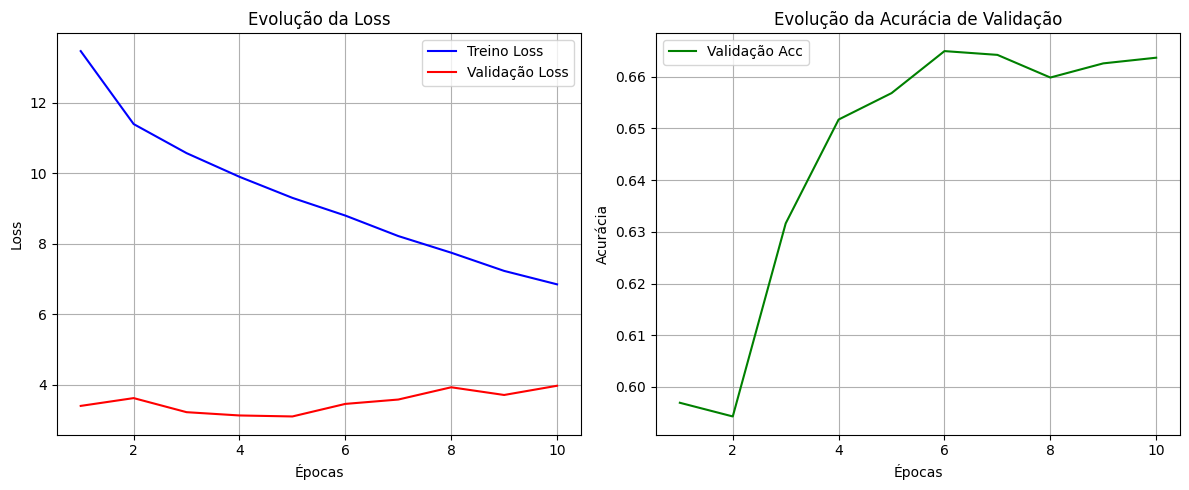


Extraindo Embeddings para Análise de Viés...
                 precision    recall  f1-score   support

          Black       0.97      0.85      0.91     12233
     East Asian       0.80      0.88      0.84     12287
         Indian       0.85      0.83      0.84     12319
Latino_Hispanic       0.63      0.72      0.68     13367
 Middle Eastern       0.78      0.69      0.73      9216
Southeast Asian       0.85      0.66      0.74     10795
          White       0.78      0.88      0.83     16527

       accuracy                           0.80     86744
      macro avg       0.81      0.79      0.79     86744
   weighted avg       0.81      0.80      0.80     86744

Gerando UMAP (pode demorar um pouco)...


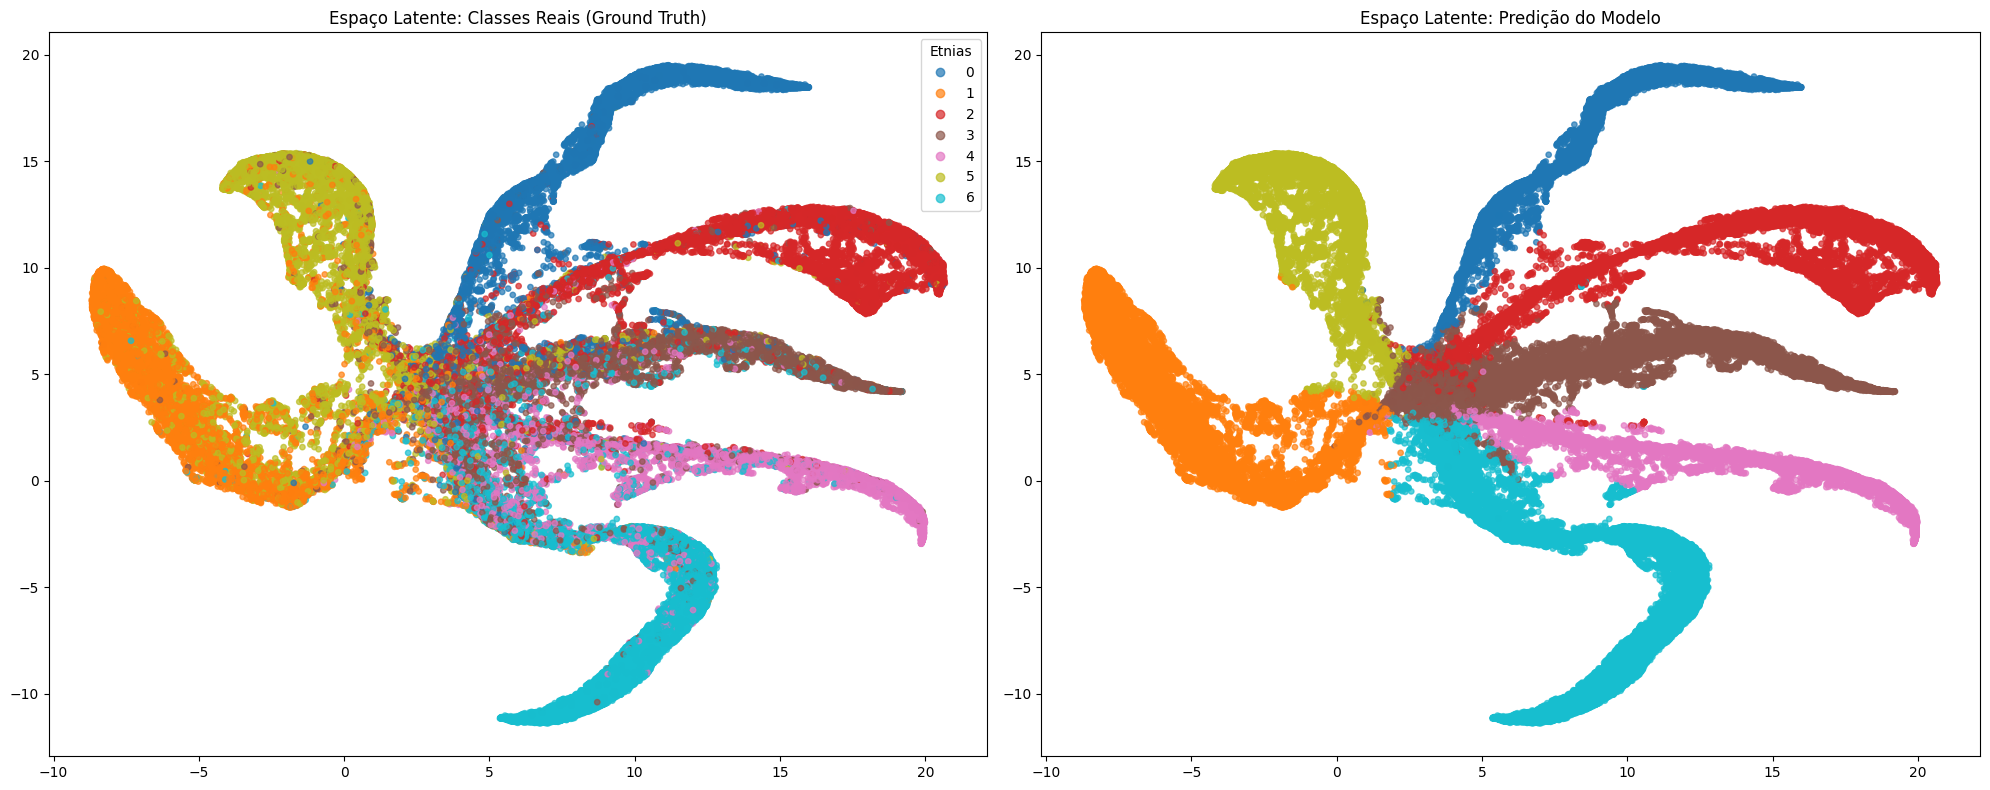


Extraindo Embeddings para Análise de Viés...
                 precision    recall  f1-score   support

          Black       0.92      0.76      0.83      1556
     East Asian       0.68      0.78      0.73      1550
         Indian       0.71      0.69      0.70      1516
Latino_Hispanic       0.46      0.55      0.50      1623
 Middle Eastern       0.61      0.53      0.57      1209
Southeast Asian       0.69      0.49      0.57      1415
          White       0.66      0.77      0.71      2085

       accuracy                           0.66     10954
      macro avg       0.68      0.65      0.66     10954
   weighted avg       0.68      0.66      0.66     10954

Gerando UMAP (pode demorar um pouco)...


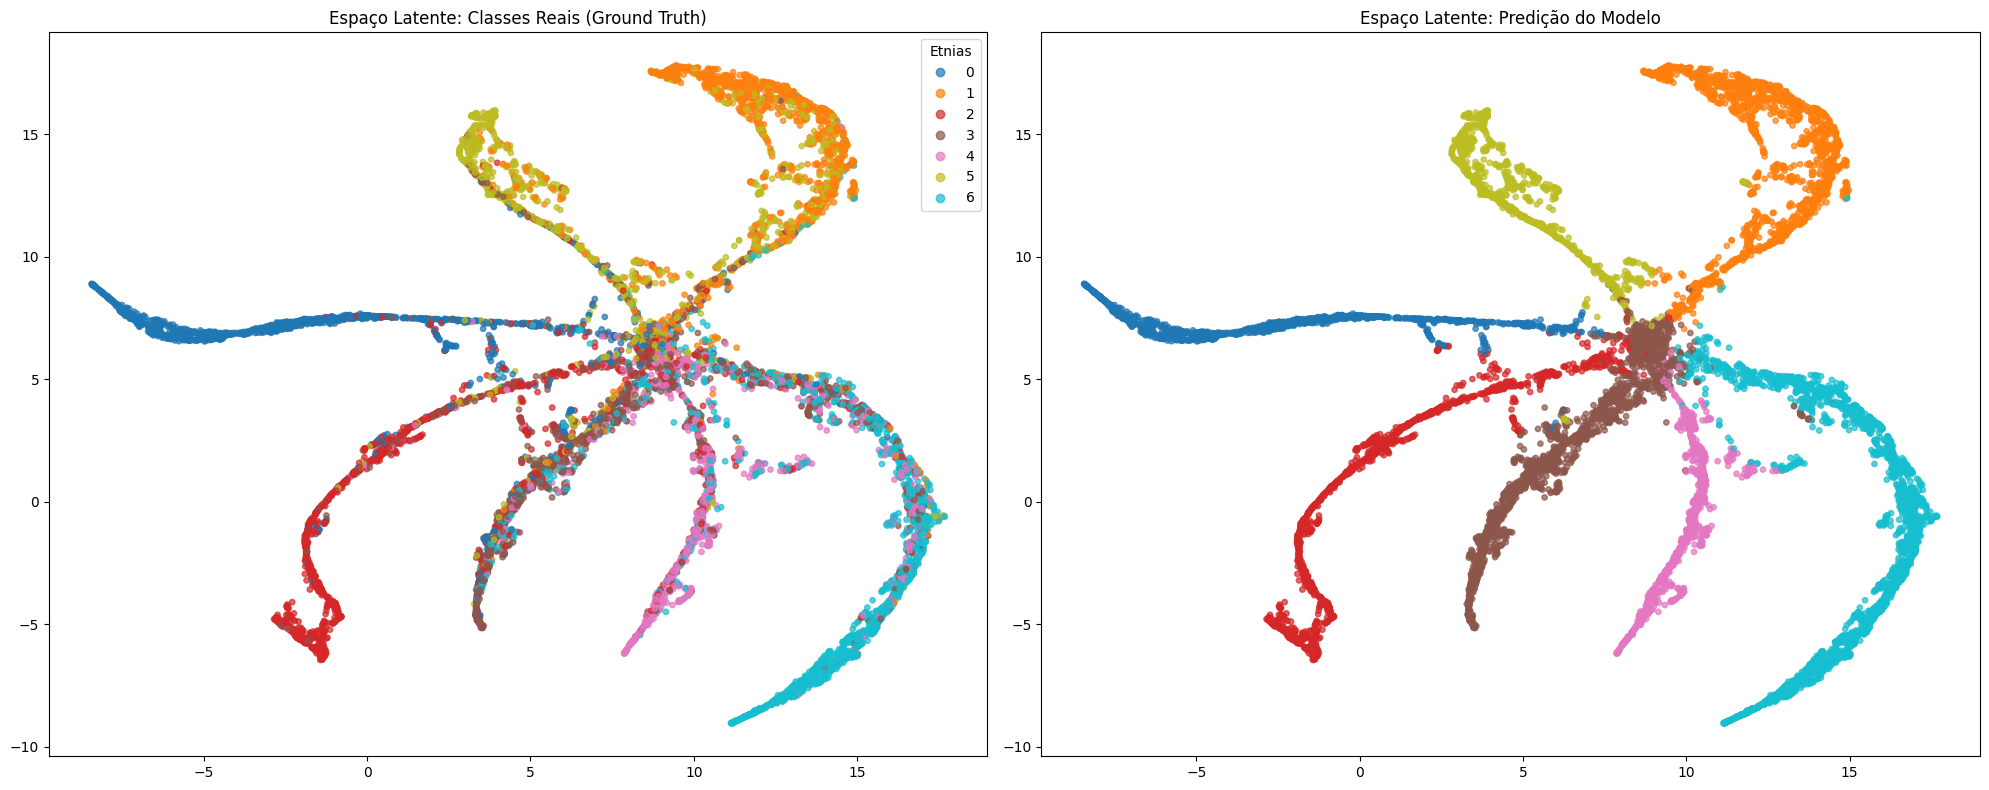

In [10]:
if __name__ == "__main__":
    dataloaders, class_names = get_dataloaders()
    CONFIG['num_classes'] = len(class_names)
    
    model = get_model(CONFIG['model_name'], CONFIG['num_classes'])
    # model.load_state_dict(torch.load('vit_b_16_2.pth', map_location=CONFIG['device']))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4) # AdamW é melhor para ViT
    
    model, history = train_model(model, dataloaders, criterion, optimizer)
    torch.save(model.state_dict(), f'{CONFIG["model_name"]}.pth')
    plot_training_history(history)
    evaluate_deia(model, dataloaders['train'], class_names)
    evaluate_deia(model, dataloaders['val'], class_names)
